In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


installs deps, 2) loads your JSONL manifests + audio, 3) builds processor/collator, 4) applies LoRA/QLoRA on Whisper (no full FT needed), 5) trains with 🤗 Trainer, 6) evaluates (BLEU/chrF), 7) saves the adapter, 8) runs a quick inference on your segments.

/content/data/

  audio_wav16/call2.wav

  segments/*.wav

  manifests/st_train.jsonl
  
  manifests/st_dev.jsonl


In [2]:
import os

# Define the source and destination paths
source_path = '/content/drive/MyDrive/whisper_t1'
destination_path = '/content/whisper_t1'

# Create a symbolic link
if not os.path.exists(destination_path):
  os.symlink(source_path, destination_path)
  print(f"Symbolic link created from '{source_path}' to '{destination_path}'")
else:
  print(f"Symbolic link already exists at '{destination_path}'")

Symbolic link created from '/content/drive/MyDrive/whisper_t1' to '/content/whisper_t1'


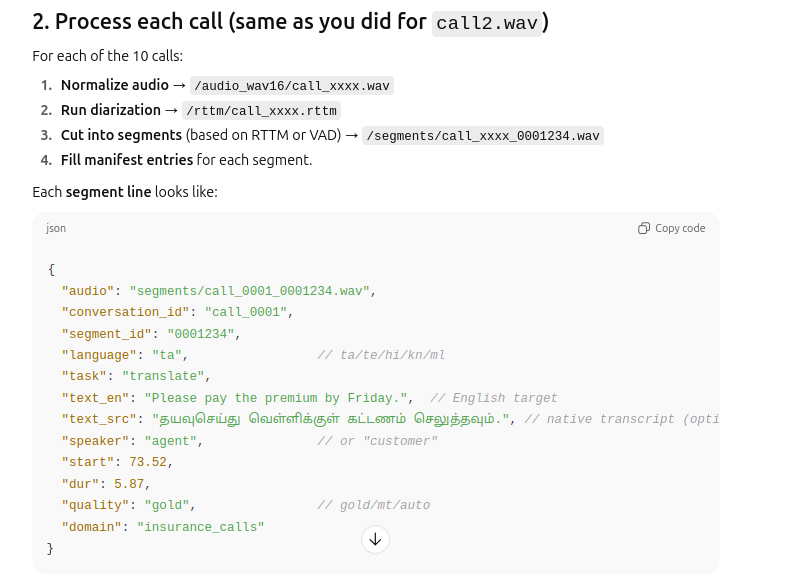

## **4. Split into train/dev/test**

In [ ]:
import json, random
from pathlib import Path
from collections import defaultdict

ROOT = Path("/dataset_root")
ALL_MAN = ROOT/"manifests/st_manifest.jsonl"

# Load all examples
all_data = [json.loads(l) for l in open(ALL_MAN)]
by_call = {}
for ex in all_data:
    cid = ex["conversation_id"]
    by_call.setdefault(cid, []).append(ex)

# All conversation IDs
cids = list(by_call.keys())
random.shuffle(cids)

# Split: 8 train, 1 dev, 1 test
train_ids = cids[:8]
dev_ids   = cids[8:9]
test_ids  = cids[9:]

def dump(ids, out_path):
    with open(out_path,"w",encoding="utf-8") as f:
        for cid in ids:
            for ex in by_call[cid]:
                f.write(json.dumps(ex, ensure_ascii=False)+"\n")

dump(train_ids, ROOT/"manifests/st_train.jsonl")
dump(dev_ids,   ROOT/"manifests/st_dev.jsonl")
dump(test_ids,  ROOT/"manifests/st_test.jsonl")


## **1) Install & imports**

In [ ]:
!pip -q install "torch==2.3.1" --index-url https://download.pytorch.org/whl/cu121
!pip -q install transformers==4.43.3 datasets==2.20.0 accelerate==0.33.0 peft==0.11.1 bitsandbytes==0.43.1
!pip -q install soundfile librosa evaluate sacrebleu jiwer rich

import os, json, math, random
from pathlib import Path
import numpy as np

import torch
from datasets import load_dataset, Audio, Dataset
from transformers import (
    WhisperFeatureExtractor, WhisperTokenizer, WhisperProcessor,
    WhisperForConditionalGeneration, TrainingArguments, Trainer
)
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
import evaluate


## **2) Paths & run settings**

In [ ]:
# Set your paths
DATA_ROOT = Path("/content/whisper_t1")      # <-- put your uploaded folder here
TRAIN_JSONL = DATA_ROOT/"manifests"/"st_train.jsonl"
DEV_JSONL   = DATA_ROOT/"manifests"/"st_dev.jsonl"

# Model + training knobs
BASE_MODEL = "openai/whisper-large-v3"  # try "small" / "medium" for quick pilots
LANG_CODE  = "ta"                       # ta/te/hi/kn/ml per this dataset
USE_QLORA  = True                       # True = QLoRA 4-bit, False = LoRA (fp16)

# Trainer hyperparams (starter)
LR = 1e-4
EPOCHS = 3
BATCH = 4
GRAD_ACCUM = 4
LOG_STEPS = 50
EVAL_STEPS = 200
SAVE_STEPS = 200

OUTPUT_DIR = "/content/whisper-st-lora"
SEED = 7
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
device


## **3) Load manifests as 🤗 Datasets (with audio decoding)**

In [ ]:
assert TRAIN_JSONL.exists(), f"Missing {TRAIN_JSONL}"
assert DEV_JSONL.exists(), f"Missing {DEV_JSONL}"

train_raw = load_dataset("json", data_files=str(TRAIN_JSONL), split="train")
dev_raw   = load_dataset("json", data_files=str(DEV_JSONL),   split="train")

# Cast 'audio' column to Audio(sampling_rate=16000) using absolute paths
def to_abs_audio_path(ex):
    # The manifest has relative paths like "segments/call2_....wav"
    ex["audio"] = str((DATA_ROOT / ex["audio"]).resolve())
    return ex

train_raw = train_raw.map(to_abs_audio_path)
dev_raw   = dev_raw.map(to_abs_audio_path)

train = train_raw.cast_column("audio", Audio(sampling_rate=16000))
dev   = dev_raw.cast_column("audio",   Audio(sampling_rate=16000))

len(train), len(dev), train[0].keys()


## **4) Processor (feature extractor + tokenizer) & collator**

In [ ]:
# Build processor
feature_extractor = WhisperFeatureExtractor.from_pretrained(BASE_MODEL)
tokenizer = WhisperTokenizer.from_pretrained(BASE_MODEL, language=None, task="translate")
processor = WhisperProcessor(feature_extractor=feature_extractor, tokenizer=tokenizer)

# Collator for Speech→English
class DataCollatorWhisperST:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, features):
        # audio arrays
        audio = [f["audio"]["array"] for f in features]
        inputs = self.processor(audio, sampling_rate=16000, return_tensors="pt")

        # English targets
        with self.processor.as_target_processor():
            labels = self.processor([f["text_en"] for f in features]).input_ids

        inputs["labels"] = labels
        return inputs

collator = DataCollatorWhisperST(processor)


## **5) (Q)LoRA model init**

In [ ]:
# Load base Whisper
dtype = torch.float16 if torch.cuda.is_available() else torch.float32
base = WhisperForConditionalGeneration.from_pretrained(
    BASE_MODEL, torch_dtype=dtype, low_cpu_mem_usage=True
)

if USE_QLORA:
    # QLoRA 4-bit
    base = prepare_model_for_kbit_training(base)
    target_modules = ["q_proj","v_proj","k_proj","out_proj","fc1","fc2"]
else:
    target_modules = ["q_proj","v_proj","k_proj","out_proj","fc1","fc2"]

peft_cfg = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=16, lora_alpha=32, lora_dropout=0.05,
    target_modules=target_modules
)

model = get_peft_model(base, peft_cfg).to(device)

# Optional: enable gradient checkpointing for memory
model.gradient_checkpointing_enable()


## **6) Preprocess to attach decoder prompts (language + task)**

In [ ]:
forced_ids = processor.get_decoder_prompt_ids(language=LANG_CODE, task="translate")
forced_ids[:6]


## **7) Metrics (BLEU/chrF)**

In [ ]:
bleu = evaluate.load("sacrebleu")
chrf = evaluate.load("chrf")

def compute_metrics(pred):
    # pred.predictions are token IDs; decode to text
    pred_ids = pred.predictions
    if isinstance(pred_ids, (list, tuple)):
        pred_ids = pred_ids[0]
    texts = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

    # labels may be padded with -100
    label_ids = pred.label_ids
    label_ids = np.where(label_ids != -100, label_ids, processor.tokenizer.pad_token_id)
    refs = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    bleu_score = bleu.compute(predictions=texts, references=[[r] for r in refs])["score"]
    chrf_score = chrf.compute(predictions=texts, references=[[r] for r in refs])["score"]
    return {"bleu": bleu_score, "chrf": chrf_score}


## **8) TrainingArguments & Trainer**

In [ ]:
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=LR,
    per_device_train_batch_size=BATCH,
    per_device_eval_batch_size=max(1, BATCH//2),
    gradient_accumulation_steps=GRAD_ACCUM,
    fp16=torch.cuda.is_available(),
    num_train_epochs=EPOCHS,
    logging_steps=LOG_STEPS,
    evaluation_strategy="steps",
    eval_steps=EVAL_STEPS,
    save_steps=SAVE_STEPS,
    save_total_limit=2,
    remove_unused_columns=False,
    dataloader_num_workers=2,
    report_to="none",
    seed=SEED
)

# Small helper: map to input features & labels for Trainer preview
def peek(ds):
    ex = ds[0]
    return {k: type(v).__name__ for k,v in ex.items()}

print("Sample example:", peek(train))

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train,
    eval_dataset=dev,
    data_collator=collator,
    tokenizer=processor.tokenizer,
    compute_metrics=compute_metrics
)


## **9) Train**

In [ ]:
trainer.train()
model.save_pretrained(f"{OUTPUT_DIR}/adapter")
processor.save_pretrained(OUTPUT_DIR)  # saves tokenizer & feature extractor


## **10) Quick eval & sample generation**

In [ ]:
# Evaluate on dev set (BLEU/chrF)
metrics = trainer.evaluate()
metrics

# Generate on a few dev samples using the LoRA-adapted model
model.eval()
def generate_text(audio_np, sr=16000, max_new_tokens=128):
    inputs = processor(audio_np, sampling_rate=sr, return_tensors="pt").input_features.to(device)
    with torch.no_grad():
        gen = model.generate(
            inputs,
            forced_decoder_ids=forced_ids,
            max_new_tokens=max_new_tokens
        )
    return processor.batch_decode(gen, skip_special_tokens=True)[0]

for i in range(min(3, len(dev))):
    ex = dev[i]
    audio_np = ex["audio"]["array"]
    pred = generate_text(audio_np)
    print(f"[{i}] REF: {ex['text_en']}\n    HYP: {pred}\n")


## **11) (Optional) Resume / continue training from checkpoint**

In [ ]:
# If training stopped, resume from the last checkpoint
# trainer.train(resume_from_checkpoint=True)


## **12) (Optional) Export for inference**

In [ ]:
from transformers import WhisperForConditionalGeneration, WhisperProcessor
from peft import PeftModel
import soundfile as sf

processor = WhisperProcessor.from_pretrained(OUTPUT_DIR)
base = WhisperForConditionalGeneration.from_pretrained(BASE_MODEL).to(device)
model = PeftModel.from_pretrained(base, f"{OUTPUT_DIR}/adapter").to(device)
model.eval()

wav_path = "/content/data/segments/call2_0001234.wav"
audio, sr = sf.read(wav_path)
text = generate_text(audio, sr)
print(text)
